# Reproducible Code Supplement to "Approximating Nonlinear Forces with Phase-Space Decoupling"
## Produced in Affiliation with ESS and Lund University

## Prerequisites:

### Jupyter notebooks:
http://jupyter.readthedocs.io/en/latest/install.html
(note that the Anaconda package is the recommended starting point for a Python/SciPy/Jupyter environment)

### Julia:
http://julialang.org/downloads/platform.html

### First, open the Julia REPL from the desired working directory:
```bash
$ julia
  _       _ _(_)_     |  A fresh approach to technical computing
  (_)     | (_) (_)    |  Documentation: http://docs.julialang.org
   _ _   _| |_  __ _   |  Type "?help" for help.
  | | | | | | |/ _` |  |
  | | |_| | | | (_| |  |  Version 0.5.0-dev+2132 (2016-01-14 11:02 UTC)
 _/ |\__'_|_|_|\__'_|  |  Commit e2f8842* (244 days old master)
|__/                   |  x86_64-apple-darwin15.2.0


julia> 

```
Then run:
```julia
Pkg.add("IJulia")
Pkg.add("MultiPoly")
Pkg.add("PyCall")
Pkg.add("PyPlot")
Pkg.add("SymPy")
Pkg.add("Plots")
```
This may take several minutes, depending on your connection.

The Julia v0.4 kernel should now available in Jupyter. For troubleshooting, see:
https://github.com/JuliaLang/IJulia.jl

For interactivity, use the ".ipynb" version of this tutorial from this point.

In Julia REPL:
```julia
using IJulia
notebook()
```
or from the shell:
```bash
jupyter notebooks
```

In [21]:
using Plots,PyPlot,MultiPoly,PyCall,SymPy
default(palette = :viridis)
@pyimport numpy as np;
@pyimport numpy.random as npr;

In [28]:
function ∇Lie(f,g,r,o) # The rudimentary Lie Operator, i.e. the Poisson bracket
    diff(f,r)*diff(g,o)-diff(g,r)*diff(f,o)
end
#
function Lietrx(f,g,r,o,order=ord)  # Taylor series for exponential Lie Transform
    step = ∇Lie(f,g,r,o)
    result = g + step
    for i = 2:order+1
        step = ∇Lie(f,step)
        result = result + step/factorial(i)
    end    
    return(result)
end

Lietrx (generic function with 4 methods)

In [45]:
m = 1.        #Particle mass, normalized to 1 amu here
k = 1.E9      #Lab: [Teslas/meters^(n-1)] *longitudinal momentum [1 GeV / c] * fundamental charge [A*s]
#k_alt = 1E13 #CoM: [T/meters^(n-1)] * fundamental charge
L = 1E-4      #magnet thin-kick lengths
Ldr = 1E-3    #interspersed drifts

qᵥ, pᵥ = generators(MPoly{Float64}, :q, :p);   #MultiPoly variables for multiparticle calcs
xᵥ = Sym("x")                                  #SymPy varibles for envelope
mᵥ = Sym("m")

Hm = -L * (k/4 * qᵥ^4+ 1/2 * pᵥ^2)           #Octupole hamiltonian (multiparticle)
#Hm_CM = -L * (k_alt/4 * pᵥ * qᵥ^4 + 1/2 * m * pᵥ^2 / 2) #CoM formalism, for reference only
Hdr =  -Ldr/2* pᵥ^2                          #Drift hamiltonian;

Hm_s = -L * (k/4 * xᵥ^4+ 1/2 * mᵥ^2)         # Same as above, for envelope
Hdr =  -Ldr/2* pᵥ^2

MultiPoly.MPoly{Float64}(-0.0005p^2)

In [54]:
npr.seed(40002)                  
σq = .001        #StDv for position [meters]
σp = .001        #StDv for momentum [meters/second]
N = 500          #Particle count
ord = 5          #Lie transform order of truncation
slc = 200        #number iterated kick--drift sections
mean, cov = [0,0], [(σq^2, 0), (0,σp^2)]       
bGau = npr.multivariate_normal(mean, cov, N)   #Generating a position/momentum bigaussian;

In [55]:
qₒ = Lietrx(Hm,qᵥ,:q,:p)      #output position/momentums for kick/drift sections, rspctv.
pₒ = Lietrx(Hm,pᵥ,:q,:p)
qₒD = Lietrx(Hdr,qᵥ,:q,:p)
pₒD = Lietrx(Hdr,pᵥ,:q,:p);

In [87]:
#= Primary argument options:
               df = default multivariate expansion (no approximation in momentum)
               zr = null momentum in q expansion
               sg = naive dual-sigmas approximation  (Eqn. 5)
               er = "star" approximation (Eqn. 15)
=#
@time function multiter(f,slices=slc)    
    qₓ,pₓ = bGau[:,1], bGau[:,2]
    qₓ₂,pₓ₂ = bGau[:,1], bGau[:,2]
    
#=    if f != "df"
        for i =1:length(qₓ)  #generator for p approximations        
            if f == "zr"
                pₓ₂[i] = 0
            elseif f == "sg"
                pₓ₂[i] = -qₓs[i]*σp/σq        
            elseif f == "er"
            e_factq = erf(qₓs[i]/(sqrt(2)*σq))/2
                rhoq = exp(-qₓs[i]^2/(2*σq^2))/sqrt(2*pi*σq^2)
            pₓ₂[i] = -exp(-2*qₓs[i]*rhoq/e_factq)*(qₓs[i])*σp/σq
            end
        end
    end
=#
    
    for j = 1:slc        
        
        if f == "df"       #kicks
            qₓ₃ = [MultiPoly.evaluate(qₒ,qₓ[i],pₓ[i]) for i = 1:length(qₓ)];
        else    
            qₓ₃ = [MultiPoly.evaluate(qₒ,qₓ[i],pₓ₂[i]) for i = 1:length(qₓ)];
        end
        pₓ₃ = [MultiPoly.evaluate(pₒ,qₓ[i],pₓ[i]) for i = 1:length(pₓ)];        
        
        #drifts    
        qₓ₃D = [MultiPoly.evaluate(qₒD,qₓ₃[i],pₓ₃[i]) for i = 1:length(qₓ)];
        pₓ₃D = [MultiPoly.evaluate(pₒD,qₓ₃[i],pₓ₃[i]) for i = 1:length(pₓ)];

        σq = np.std(qₓ₃D)   #Re-setting stdv values
        σp = np.std(pₓ₃D)    
            
        if f != "df"        
            for i =1:length(qₓ)
                if f == "zr"
                    pₓ₂[i] = 0
                elseif f == "sg"
                    pₓ₂[i] = -qₓ₃D[i]*σp/σq        
                elseif f == "er"
                    e_factq = erf(qₓ₃D[i]/(sqrt(2)*σq))/2
                    rhoq = exp(-qₓ₃D[i]^2/(2*σq^2))/sqrt(2*pi*σq^2)
                    pₓ₂[i] = -exp(-2*qₓ₃D[i]*rhoq/e_factq)*(qₓ₃D[i])*σp/σq
                end
             end
        end
         qₓ = copy(qₓ₃D)    
         pₓ = copy(pₓ₃D) 
    end
    return(qₓ,pₓ)
end

  0.000144 seconds (14 allocations: 6.168 KB)


multiter (generic function with 2 methods)

In [88]:
qₓdf, pₓdf =multiter("df");
qₓzr, pₓzr =multiter("zr");
qₓsg, pₓsg =multiter("sg");
qₓer, pₓer =multiter("er");


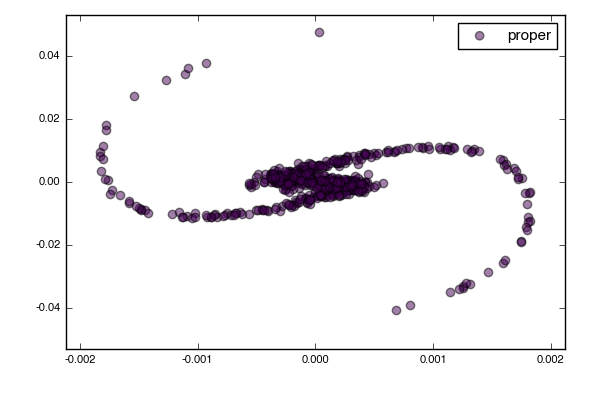

In [91]:
Plots.scatter(qₓdf,pₓdf,alpha=.5,grid=false,label="proper")
#=Plots.scatter!(qₓs2,pₓs2,alpha=.5,label="erfs")
Plots.scatter!(qₓs3,pₓs3,alpha=.5,grid=false,label="zers")
Plots.scatter!(qₓs4,pₓs4,alpha=.5,grid=false,label="sigs")=#

plot!(ylim=(-.05,.05))
plot!(xlim=(-.002,.002))

# plot!(margin=35px,top_margin=15px,
# legendfont=Plots.font("Helvetica",11))
plot!(margin=35px,top_margin=15px,
legendfont=Plots.font("Helvetica",11))

In [14]:
#sigs
qstale = copy(qₓs)
pstale = copy(pₓs)
#qstale1 = copy(qₓs)
#pstale1 = copy(pₓs)
#qstale2 = copy(qₓs)
#pstale2 = copy(pₓs)
#qstale3 = copy(qₓs)
#pstale3 = copy(pₓs)
#qstale4 = copy(qₓs)
#pstale4 = copy(pₓs)

#writedlm("/Users/benfolsom/Desktop/bestest/qlamb.txt",qstale)
#writedlm("/Users/benfolsom/Desktop/bestest/plamb.txt",qstale)

# writedlm("/Users/benfolsom/Desktop/bestest/qerf.txt",qstale)
# writedlm("/Users/benfolsom/Desktop/bestest/perf.txt",qstale)

# writedlm("/Users/benfolsom/Desktop/bestest/qxsig.txt",qstale1)
# writedlm("/Users/benfolsom/Desktop/bestest/pxsig.txt",qstale1)

# writedlm("/Users/benfolsom/Desktop/bestest/qx0.txt",qstale2)
# writedlm("/Users/benfolsom/Desktop/bestest/px0.txt",qstale2)

# writedlm("/Users/benfolsom/Desktop/bestest/qZs.txt",qstale3)
# writedlm("/Users/benfolsom/Desktop/bestest/pZs.txt",qstale3);

In [15]:
#Plots.scatter(qstale3,pstale3,alpha=.5,label = L"x_L(x_0,p=0)",m=(:diamond,5.5))
Plots.scatter(qstale,pstale,alpha=.7,m=(:diamond,6.5),
label = L"x_L(x_0,p^*), \ p^*=f(\mathrm{erf}(g(x_0))")
Plots.scatter!(qstale2,pstale2,alpha=.5,m=(:star4,8.5),grid=false,
label = L"x_L(x_0,p_0)")
#Plots.scatter!(qstale4,pstale4,alpha=.81,m=(:c,6.5),
#label = L"x_L(x_0,p^*), \ p^*=x_0\cdot \sigma_p / \sigma_x")
#Plots.scatter!(qstale3,pstale3,alpha=.75,
#label = L"x_L(x_0,p=0)",m=(:diamond,5.5))


plot!(ylim=(-112,130))
plot!(xlim=(-1.8,1.8))
xlabel!(L"x_L\rm{[mm]}")
ylabel!(L"p_L(x_0,p_0)\rm{[mm/mrad]}")
#
plot!(margin=15px,top_margin=25px,bottom_margin=5px,
legendfont=Plots.font("Helvetica",11))
#png("/Users/benfolsom/Desktop/bestest/sigs")

LoadError: LoadError: UndefVarError: qstale2 not defined
while loading In[15], in expression starting on line 4


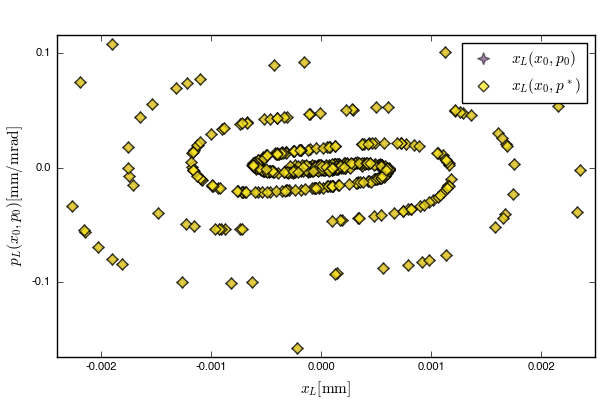

In [16]:
Plots.scatter(qₓs1,pₓs1,alpha=.5,m=(:star4,8.5),grid=false,
label = L"x_L(x_0,p_0)")
Plots.scatter!(qₓs2,pₓs2,alpha=.75,
label = L"x_L(x_0,p^*)",m=(:diamond,5.5))
#plot!(ylim=(-112,130))
#plot!(xlim=(-1.8,1.8))
xlabel!(L"x_L\rm{[mm]}")
ylabel!(L"p_L(x_0,p_0)\rm{[mm/mrad]}")
#
plot!(margin=5px,top_margin=35px,bottom_margin=1px,
legendfont=Plots.font("Helvetica",11))
#png("/Users/benfolsom/Desktop/bestest/sigs")


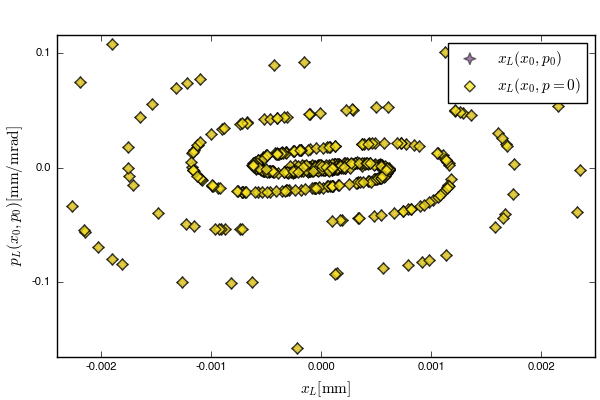

In [17]:
Plots.scatter(qₓs1,pₓs1,alpha=.5,m=(:star4,8.5),grid=false,
label = L"x_L(x_0,p_0)")
Plots.scatter!(qₓs3,pₓs3,alpha=.75,
label = L"x_L(x_0,p=0)",m=(:diamond,5.5))
#plot!(ylim=(-112,130))
#plot!(xlim=(-1.8,1.8))
xlabel!(L"x_L\rm{[mm]}")
ylabel!(L"p_L(x_0,p_0)\rm{[mm/mrad]}")
#
plot!(margin=5px,top_margin=35px,bottom_margin=1px,
legendfont=Plots.font("Helvetica",11))
#png("/Users/benfolsom/Desktop/bestest/zeros")


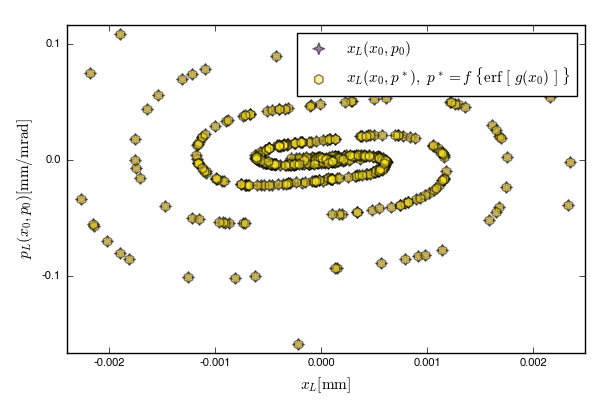

In [18]:
#erfs
Plots.scatter(qₓs1,pₓs1,alpha=.5,m=(:star4,8.5),grid=false,
label = L"x_L(x_0,p_0)")
Plots.scatter!(qₓs4,pₓs4,alpha=.5,m=(:h,7),
label = L"x_L(x_0,p^*), \ p^*=f \ \{ \mathrm{erf} \ [ \ g(x_0) \ ] \ \}")


#plot!(ylim=(-112,130))
#plot!(xlim=(-1.8,1.8))
xlabel!(L"x_L\rm{[mm]}")
ylabel!(L"p_L(x_0,p_0)\rm{[mm/mrad]}")
#
plot!(margin=15px,top_margin=25px,bottom_margin=5px,
legendfont=Plots.font("Helvetica",11))

#png("/Users/benfolsom/Desktop/bestest/erf")

In [ ]:
qₒ = Lietrx(Hm,qᵥ);
pₒ = Lietrx(Hm,pᵥ);

@time for i = 1:go     
    qₒ2 = copy(Lietrx(Hm,qₒ));
    pₒ2 = copy(Lietrx(Hm,pₒ));

    qₒ = copy(qₒ2)
    pₒ = copy(pₒ2)
end
qₒⱼ = derivative(qₒ,1)*derivative(pₒ,2)-derivative(qₒ,2)*derivative(pₒ,1)
qₓₒⱼ = [(evaluate(qₒⱼ,[qstale2[i],pstale2[i]])) for i = 1:length(qₓ)];
qₓ₂ⱼ = [(evaluate(qₒⱼ,[qstale[i],pstale[i]])) for i = 1:length(qₓ)];
#qₓ₂ⱼ = qₓ₂ⱼ[np.logical_not(np.isnan(qₓ₂ⱼ))];

In [ ]:
np.mean(qₓ₂ⱼ)

In [ ]:
np.mean(qₓₒⱼ)

In [ ]:
xpr = 2#3E-12
BS = 100

histogram(qₓₒⱼ,label = L"|J(x_L(x_0,p_0),p_L(x_0,p_0))|",bins=BS,norm=false,linealpha=0.2, alpha = 0.85)
histogram!(qₓ₂ⱼ,label = L"|J(x_L(x_0,p^*),p_L(x_0,p_0)|",bins=BS,norm=false,linealpha=0.2, alpha = 0.85)

plot!(margin=35px,top_margin=15px,
legendfont=Plots.font("Helvetica",11))
#title!("sigs")
title!("erfs")
plot!(xlim=(-xpr+1,xpr+1))

In [ ]:
xpr = 3E-12
BS = 150

#histogram(qₓₒⱼ,label = L"|J(x_0,p_0)|",bins=BS,norm=false,linealpha=0.2, alpha = 0.85)
histogram(qₓ₂ⱼ,label = L"|J(x_0,p^*)|",bins=BS,norm=false,linealpha=0.2, alpha = 0.85)

plot!(margin=35px,top_margin=15px,
legendfont=Plots.font("Helvetica",11))
#title!("sigs")
title!("erfs")
plot!(xlim=(-xpr+1,xpr+1))